In [62]:
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ElementTree
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#ONLY RUN THIS TO GET THE CSV FILE, NO NEED IF FILE EXISTS
#REMEMBER TO CHANGE THIS TO FMCS URL IN LIVE SERVER
#http://131.243.229.11/setup/loggersetup.cgi?ADDRESS=42&REFRESH=Advanced, signal strength
#http://131.243.229.11/setup/devlist.cgi?SETUP=XML, device list
devices_xml = requests.get("http://131.243.229.11/setup/devlist.cgi?SETUP=XML", auth=('admin', '8o14i^Km')).text
tree = ET.ElementTree(ET.fromstring(devices_xml))

root = tree.getroot()
device_names = []

for address in root.iter('device'):
    device_names.append(address.attrib['address'])
    
device_names.remove('250')

In [3]:
#ONLY RUN THIS TO GET THE CSV FILE, NO NEED IF FILE EXISTS
#Use to test beautiful soup, need to filter maybe
test = requests.get("http://131.243.229.11/setup/loggersetup.cgi?ADDRESS=42&REFRESH=Advanced", 
                    auth=('admin', '8o14i^Km')).text
soup_test = BeautifulSoup(test)
print(soup_test.prettify())

<html>
 <head>
  <title>
  </title>
  <meta content="Stephen Herzog, for Obvius Holdings LLC" name="AUTHOR"/>
  <meta content="Copyright 2001-2016 by Obvius Holdings LLC, All Rights Reserved." name="COPYRIGHT"/>
  <meta content="SDProxy: portions Copyright 1999-2003 by Secure Design, All Rights Reserved." name="COPYRIGHT"/>
  <meta content="Network Setup Pages" name="KEYWORDS"/>
  <meta content="Setup pages for this server" name="DESCRIPTION"/>
  <meta content="Acquisuite cgi application" name="GENERATOR"/>
  <meta content="Sep 19 2016 15:51:51 Pacific" name="COMPILEDATE"/>
  <meta content="$Id: dev_r9120.cpp,v 1.87 2016/07/28 16:37:01 alevy Exp $" name="SOURCE"/>
  <meta content="width=device-width" name="viewport"/>
  <link href="/style.css" media="all" rel="stylesheet" type="text/css"/>
 </head>
 <body bgcolor="#FFFFFF" topmargin="5">
  <script language="JavaScript" src="relaybutton.js" type="text/javascript">
  </script>
  <form action="loggersetup.cgi?ADDRESS=42&amp;T=336D&amp;REF

In [4]:
#ONLY RUN THIS TO GET THE CSV FILE, NO NEED IF FILE EXISTS
data_frame = pd.DataFrame()

for device in device_names:
    html_string = requests.get("http://131.243.229.11/setup/loggersetup.cgi?ADDRESS=" + str(device) + "&REFRESH=Advanced",
                              auth=('admin', '8o14i^Km')).text
    text = BeautifulSoup(html_string).get_text()
    
    test_devices = device_names.copy()
    test_devices.remove(device)
    signals = []
    
    for line in text.splitlines():
        address = re.match(r'(Address:) ([0-9]+)', line)
        if address and address[2] in device_names:
            if re.search(r'[0-9]+%', line):
                signals.append(re.search(r'[0-9]+%', line)[0])
            else:
                signals.append('NaN')
            
    if len(signals)==0:
        data_frame[device] = np.full(len(test_devices) + 1, "NaN")
    else:
        column = pd.Series(signals, index=list(map(int, test_devices)))
        column = column.append(pd.Series(["100%"], index=[int(device)])).sort_index()
        data_frame[device] = column

In [5]:
#ONLY RUN THIS TO GET THE CSV FILE, NO NEED IF FILE EXISTS
#Nuances: When mapping an address to itself (42->42), I assume 100% signal strength. Also, devices where there is an error
#give back a NaN column. Also note that this is a column to row relationship, as in, I am only taking data from what is given
#from the respective column address data. For instance, if address 24 says its strength to 42 is 22%, that is true for column
#24 matched to row 42. That is not true for column 42 to row 24! 
data_frame

,24,25,28,29,30,31,32,33,34,36,37,40,41,42,43,44,48,49
24,100%,NaN,1%,5%,7%,NaN,10%,3%,6%,4%,NaN,2%,8%,24%,11%,6%,16%,1%
25,1%,NaN,NaN,18%,4%,NaN,13%,6%,6%,5%,NaN,15%,6%,5%,6%,4%,7%,4%
28,1%,NaN,100%,3%,4%,NaN,13%,6%,6%,4%,NaN,2%,1%,5%,6%,4%,7%,4%
29,11%,NaN,3%,100%,22%,NaN,62%,9%,20%,1%,NaN,47%,7%,1%,19%,31%,1%,1%
30,9%,NaN,0%,25%,100%,NaN,55%,10%,30%,27%,NaN,11%,24%,1%,8%,30%,1%,1%
31,9%,NaN,4%,25%,NaN,NaN,55%,35%,30%,27%,NaN,11%,24%,25%,31%,30%,35%,21%
32,12%,NaN,1%,48%,54%,NaN,100%,68%,57%,50%,NaN,3%,54%,47%,58%,54%,65%,39%
33,9%,NaN,5%,7%,10%,NaN,67%,100%,10%,2%,NaN,14%,15%,1%,5%,16%,1%,1%
34,10%,NaN,4%,26%,27%,NaN,56%,8%,100%,26%,NaN,1%,21%,2%,16%,34%,35%,1%
36,8%,NaN,4%,1%,1%,NaN,50%,2%,1%,100%,NaN,10%,1%,7%,35%,1%,1%,1%


In [2]:
#ONLY RUN THIS TO GET THE CSV FILE, NO NEED IF FILE EXISTS
data_frame = data_frame.reset_index()
data_frame.to_csv("signal_strength.csv", index=False)

NameError: name 'data_frame' is not defined

In [63]:
tbl = pd.read_csv('signal_strength.csv').set_index('index')
tbl

,24,25,28,29,30,31,32,33,34,36,37,40,41,42,43,44,48,49
index,,,,,,,,,,,,,,,,,,
24,100%,NaN,1%,5%,7%,NaN,10%,3%,6%,4%,NaN,2%,8%,24%,11%,6%,16%,1%
25,1%,NaN,NaN,18%,4%,NaN,13%,6%,6%,5%,NaN,15%,6%,5%,6%,4%,7%,4%
28,1%,NaN,100%,3%,4%,NaN,13%,6%,6%,4%,NaN,2%,1%,5%,6%,4%,7%,4%
29,11%,NaN,3%,100%,22%,NaN,62%,9%,20%,1%,NaN,47%,7%,1%,19%,31%,1%,1%
30,9%,NaN,0%,25%,100%,NaN,55%,10%,30%,27%,NaN,11%,24%,1%,8%,30%,1%,1%
31,9%,NaN,4%,25%,NaN,NaN,55%,35%,30%,27%,NaN,11%,24%,25%,31%,30%,35%,21%
32,12%,NaN,1%,48%,54%,NaN,100%,68%,57%,50%,NaN,3%,54%,47%,58%,54%,65%,39%
33,9%,NaN,5%,7%,10%,NaN,67%,100%,10%,2%,NaN,14%,15%,1%,5%,16%,1%,1%
34,10%,NaN,4%,26%,27%,NaN,56%,8%,100%,26%,NaN,1%,21%,2%,16%,34%,35%,1%


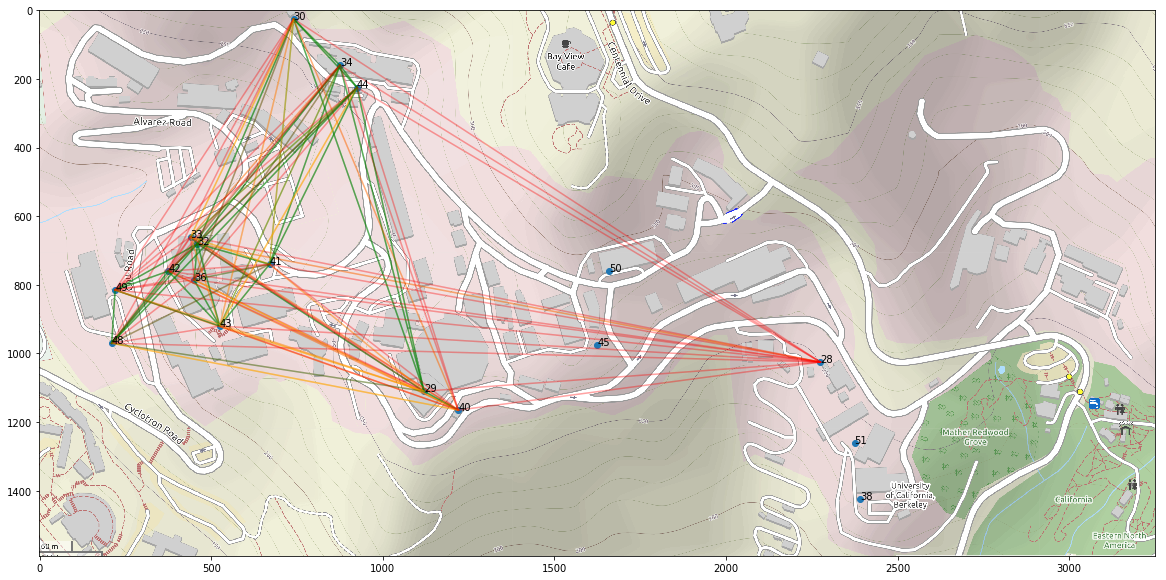

In [65]:
#THIS SECTION IS TO PLOT THE POINTS, NEED THE CSV FILE TO PROCEED
#NOTES: This code can be easily altered! If you think the colors need different parameters (ie, want red lines for percents
#up to 20%) you can change that in the if elif block. 
img = plt.imread("lbnl_map.png")
fig, ax = plt.subplots()
fig.set_size_inches(20, 13)

#initializing the device points, from left to right
#First make a mapping of each device and their points
#Note that you can alter the devices list safely, as long as you also add the appropriate x,y coordinates in the 
#x and y list. Please note that order matters here! Each index of devices should properly align in coordinates with the
#indexes in the x and y lists.
devices = [48, 49, 42, 33, 36, 32, 43, 41, 30, 34, 44, 29, 40, 45, 50, 28, 51, 38]
x = [210, 220, 375, 440, 450, 460, 525, 670, 740, 875, 925, 1120, 1220, 1625, 1660, 2275, 2375, 2390]
y = [970, 815, 760, 660, 785, 680, 920, 740, 25, 160, 225, 1110, 1165, 975, 760, 1025, 1260, 1425]

#This is needed for line plotting
x_dict = dict(zip(devices, x))
y_dict = dict(zip(devices, y))

#Plotting the points
plt.scatter(x, y)

#Plotting the names of the points
for i, txt in enumerate(devices):
    ax.annotate(txt, (x[i], y[i]))
    
#The workhorse of the notebook, this actually plots the lines.    
for index, row in tbl.iterrows():
    #If the index exists in our listed devices, continue
    if int(index) in devices:
        for device in devices:
            #If the device exists in our data table csv, continue
            if str(device) in tbl.columns:
                
                #Note the implicit hierarchy here! We must go in ascending order of if statements,
                #since the lower numbers will get "caught" and not interfere with the higher numbers
                #i.e. you don't want 9% be in the <20 if block, so we "catch" it in the <10 block that was 
                #written first.
                
                #Also, the alpha param controls depth of color. If you want a bolder color, increase alpha (min=0.0, max=1.0)
                #If the signal strength is less than 10 and we don't have a NaN value, plot red lines
                if int(row[str(device)][:-1]) < 10 and row[str(device)][:-1] != 'NaN':
                    plt.plot([x_dict[int(index)], x_dict[int(device)]], 
                             [y_dict[int(index)], y_dict[int(device)]], color='r', alpha=0.2)
                #If the signal strength is less than 20 and we don't have a NaN value, plot orange lines
                elif int(row[str(device)][:-1]) < 20 and row[str(device)][:-1] != 'NaN':
                    plt.plot([x_dict[int(index)], x_dict[int(device)]], 
                             [y_dict[int(index)], y_dict[int(device)]], color='orange', alpha=0.4)
                #If the signal strength is 20 or above and we don't have a NaN value, plot green lines
                elif int(row[str(device)][:-1]) >= 20 and row[str(device)][:-1] != 'NaN':
                    plt.plot([x_dict[int(index)], x_dict[int(device)]], 
                             [y_dict[int(index)], y_dict[int(device)]], color='green', alpha=0.4)           

#Overlap the image over the plot
ax.imshow(img)

#Save the plot
plt.savefig('signal_map.png')